In [4]:
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib
import scipy as sci
import scipy.ndimage
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import RectBivariateSpline
from astropy.cosmology import Planck15, z_at_value
from astropy import coordinates as coord
import astropy.constants as const
import astropy.units as unit
import healpy as hp
from datetime import datetime
from functools import partial 
import sys, platform, os
from IPython.display import Image,display

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

# Algorithm

## Build lightcone

Construct matter lightcone from Gadget simulation snapshots

Done already.

## Generate density maps
For each lens plane (initially use lightcone snapshot shell per lensplane -> 20 lensplanes up to $z=0.85$)
map particle count onto full sky map using *healpix*, to obtain the (projected) surface mass overdensity  $\Delta^{(k)}_{
\Sigma^{\theta}}({\bf \hat{n}}) =  \Sigma^{\theta}({\bf \hat{n}}) - \langle \Sigma^{\theta}
\rangle$.

(Fabbian 2018 used maps having an angular resolution of 52 arcsec corresponding to a NSIDE parameter 4096.)

## Calculate convergence maps
The lensing potential for each matter shell $k$ is the solution of the Poisson equation, i.e.
$$ \nabla^2_{\hat{n}} \Phi^{(k)}(\boldsymbol\beta^{(k)}) = 2 K^{(k)}(\boldsymbol\beta^{(k)}) $$
where the convergence field $K^{(k)}$ at the $k$-th shell is
$$ K^{(k)}(\boldsymbol\beta^{(k)}) = \frac{4 \pi  G}{c^2}\frac{D_A(\chi_k)}{(1+z_k)^2}\Delta^{(k)}_{\Sigma}(\boldsymbol\beta^{(k)})$$

Calculate harmonic coefficients of convergence field $K^{(k)}_{\ell m}$ by solving the Poisson equation in the harmonic domain as $\psi^{(k)}_{\ell m}=-2K^{(k)}_{\ell m}/[\ell(\ell+1)]$, using intitally the *map2alm* function in healpix, but possibly subseqently using the parallel SPH routines in *S2HAT*.

- convert surface mass overdensity map to $K_{\ell m}$ using healpix map2alm
- divide $K_{\ell m}$ by ${-\ell(\ell+1)}$ to calculate $\psi_{\ell m}$
- use alm2map_der1 to generate $\psi$ map as well as first and second derivatives of $\psi$ with respect to $\theta_i$ and $\theta_j$ to construct magnification matrix $\cal{A}(\boldsymbol{\vec\theta})$

using
$\cal{A}(\boldsymbol{\vec\theta})=\left(\delta_{ij}-\dfrac{\partial^2 \psi(\boldsymbol{\vec\theta)}}{\partial\theta_i \partial\theta_j} \right)$

$$\rightarrow \cal{A}(\boldsymbol{\vec\theta})=\left( 
\begin{array}{cc}
 1 - \psi_{,11}  & \psi_{,12} \\
      \psi_{,21} & 1 - \psi_{,22}     
\end{array}
\right)$$


## Perform raytracing

Propagate magnification matrix  $\cal{A}(\boldsymbol{\vec\theta})$ for each pixel ('ray') through all lens planes:
$$
A^{N}_{ij}(\boldsymbol\theta, \chi_{s}) = \delta^{K}_{ij} - \sum^{N-1}_{k=0}
\frac{\chi_{N} - \chi_{k}}{\chi_{k}} U^{(k)}_{ij}(\boldsymbol\theta,\chi_{k})
$$

where $U^{(k)}_{ij}$ is the shear matrix, defined as
$$
\textbf{U}^{(k)}_{ij}=\frac{\partial^2\psi^{(k)}(\vec{\beta}^{(k)})}{\partial \beta^{(k)}_i\partial \beta^{(k)}_j} = \frac{\partial\alpha^{(k)}_i(\vec{\beta}^{(k)})}{\partial \beta^{(k)}_j}.
$$

Rather than summing up over all preceeding lens planes, we can use only the two preceeding planes to calculate the magnification matrix for the current plane
$$ A^{(k)}_{ij} = \left( 1 - \frac{\chi_{k-1}}{\chi_k} \frac{(\chi_{k} - \chi_{k-2})}{(\chi_{k-1}- \chi_{k-2})} \right) A^{(k-2)}_{ij} 
+ \frac{\chi_{k}}{\chi_{k-1}}\frac{(\chi_{k}-\chi_{k-2})}{(\chi_{k-1} - \chi_{k-2})} A^{(k-1)}_{ij}
- \frac{(\chi_{k} - \chi_{k-1})}{\chi_{k}} U^{(k-1)}_{ip} A^{(k-1)}_{pj} $$


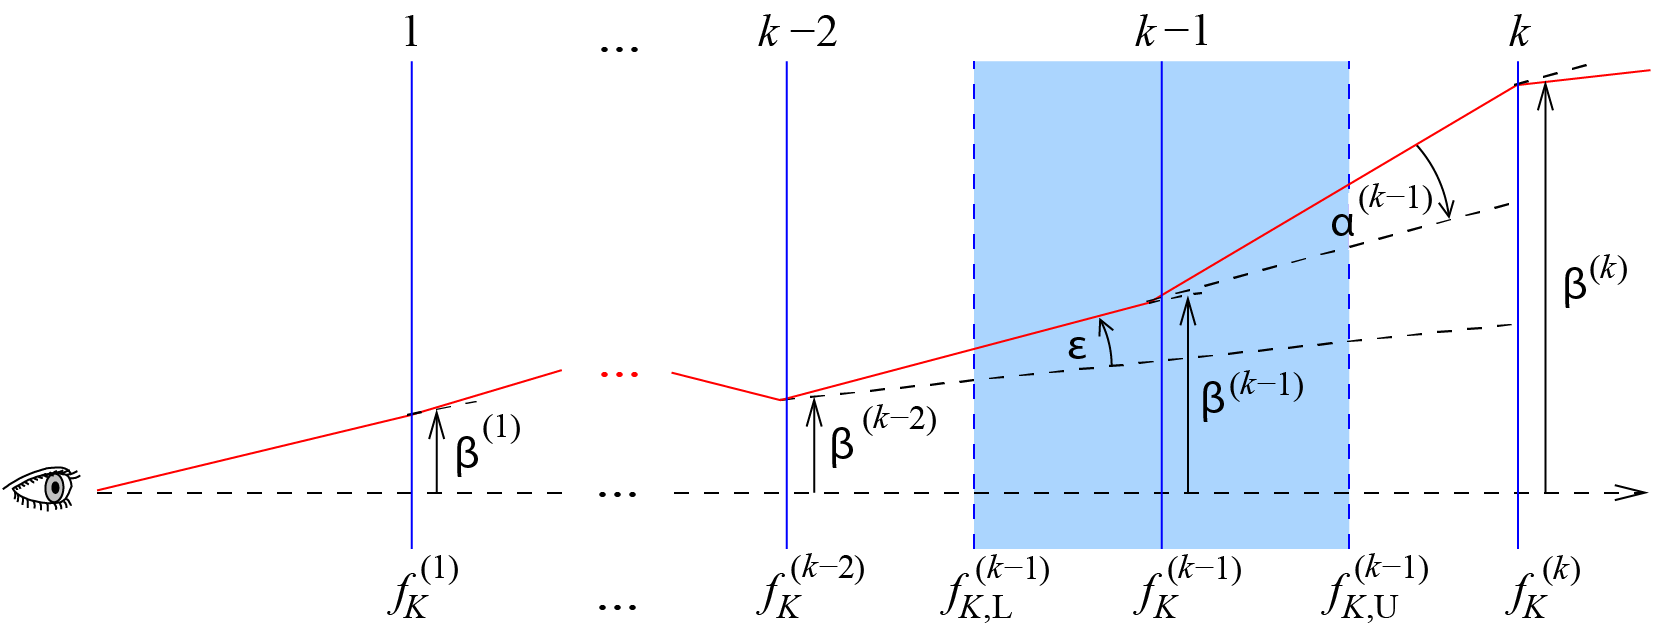

In [6]:
Image(filename='light_cone.png')

## Calculate convergence and shear maps

$\cal{A}(\boldsymbol{\vec\theta})= \left( \begin{array}{cc}
 1 - \kappa - \gamma_1     & -\gamma_2 \\
   -\gamma_2       & 1-\kappa+\gamma_1     
\end{array}\right)$

$\gamma_1 = \frac{1}{2}(\psi_{,11} - \psi_{,22}) = \frac{1}{2}(\cal{A}_{11} -\cal{A}_{22})$

$\gamma_2 = \psi_{,12}= \psi_{,21}  = \cal{A}_{12}   = \cal{A}_{21}$

$\gamma \equiv \gamma_1 + i\gamma_2 = |\gamma| e^{2i\psi} $

$\displaystyle \kappa ({\vec {\theta }})= \frac{1}{2}\left(\psi_{,11} + \psi_{,22} \right) = \frac{1}{2}(\cal{A}_{11} +\cal{A}_{22})$

## Alernative methodology
(cf. Kilbinger 2016)
$$
  \left\langle \gamma_{\rm t} \right\rangle (\theta)
  =  \bar \kappa (\le \theta) - \left\langle \kappa \right \rangle (\theta) 
$$

We can express $\langle \gamma_{\rm t} \rangle$ in terms of a *surface
mass excess* as follows. In the case of a single lens localised at angular
diameter distance $D_{\rm l}$, we can approximate $\kappa$ with
$$
  \kappa(\vec \theta) = \frac{4 \pi G}{c^2} \frac{D_{\rm l} D_{\rm ls}}{D_{\rm s}} \int\limits_{D_{\rm l} - \Delta D/2}^{D_{\rm l} + \Delta D/2}
  {\rm d} D \, \Delta \rho(D \vec \theta, D),
$$

where $D_{\rm s}$ is the distance to the source, and $D_{\rm ls}$ the distance
between lens and source. All distances in this and subsequent equations are proper distance.
The integral over the lens mass density contrast
$\Delta \rho = \rho - \bar \rho = \bar \rho \delta$ is carried out along the physical
extent of the mass
concentration $\Delta D$. This integral is defined as *surface mass density* $\Sigma$.
Introducing the critical surface mass density $\Sigma_{\rm cr}^{-1} = (4\pi G/c^2) (D_{\rm l}D_{\rm ls}/D_{\rm s})$,
the convergence is simply
$$   \kappa(\vec \theta) = \frac {\Sigma(\vec \theta)} {\Sigma_{\rm cr}} $$

Then shear can be written in terms of the surface mass as
$$ 
  \left \langle \gamma_{\rm t} \right\rangle (\theta) \, \Sigma_{\rm cr} = \Delta \Sigma(\le \theta) = \bar \Sigma(\theta) -
  \left \langle \Sigma \right \rangle (\theta) 
$$

where $\displaystyle \Sigma_{crit}^{-1}= \frac{4 \pi G}{c^2}\frac{\chi_{d}(\chi_{s}-\chi_{d})}{\chi_s}$

$$
 \kappa (\vec{\theta}, \chi)= \frac{4 \pi G}{c^2}\frac{1}{\chi_{s}}\!\sum_{i} (1 + z^{(i)}) \frac{(\chi_{s}-\chi_{d}^{(i)})}{\chi_d^{(i)}}\left[\Sigma^{(i)}(\vec{\theta})\!-\!\bar{\Sigma}^{(i)}\right]
$$
where $\Sigma^{(i)}$ denotes the angular surface mass density, $\bar{\Sigma}^{(i)}$ is the mean angular surface mass density of the $i$-th shell, and $f_{DS}^{(i)}$ and $f_D^{(i)}$ are the corresponding distances at the redshift of the $i$-th shell. The angular position of the center of each \healpix{} pixel coincides with the direction of propagation of the rays in the Born approximation.

Can also be written as


$$ \kappa(\theta) = {3H_0^2\Omega_m\over{2c^2}}~\int ~dr~\delta(\chi,\theta)~(1 + z)~\frac{\chi_{d}(\chi_{s}-\chi_{d})}{\chi_s} $$ 

where $\delta$ is the 3D matter density at comoving radial distance $\chi$ and angular position $\theta$

Build our convergence map by just adding the onion slices from the simulation with the appropriate lensing weight. This can be done as
follows:

$$ \kappa(i) = {3H_0^2\Omega_m\over{2c^2}}~\sum_j ~\delta(i,j)~(1 + z^{(j)})~\frac{\chi_{d}^{(j)}(\chi_{s}-\chi_{d}^{(j)})}{\chi_s}~d\chi_j$$ 

where $i$ indicates a pixel position in the sky and $j$ a radial bin
(at distance $r_j$ of width $dr_j$) into which we have sliced 
the simulation as described in the previous section. 
If we indicate by $N_{ij}$ the number of particles in pixel $i$ 
from onion slice $j$, we have:

$$ \delta(i,j)={\rho(i,j)\over{\bar{\rho}}}-1 $$
where $\bar{\rho}= <\rho(i,j)>$ and

$$ \rho(i,j) = {N_{ij}\over{dV_j}} = {N_{ij}\over{\Delta\Omega ~r_j^2~ dr_j}}$$
where $\Delta\Omega$ is the area of each pixel. 


## Get snapshot data from lightcone

In [7]:
# read particle data from lightcone 
def add_snapshot(snap):
    ngals = 0
    gals = []
    fname = 'galaxy_lightcone.snap{0:02d}'.format(snap)
    with h5py.File(fpath+fname,'r') as fi:
        for k in fi.keys():
            gals = fi[k]
            r.extend(gals['r'])
            ra.extend(gals['RA'])
            dec.extend(gals['Dec'])
        ngals += len(gals)
    return ngals

In [8]:
fpath = '/cosma6/data/dp004/dc-boot5/Lightcone/Galaxy_FullSky/'
# Initialise data arrays
r = []
ra = []
dec = []

In [ ]:
# read from range of lightcone snapshots
totgals = 0
galaxies  = []
for snap in range(57,64):
    ngals =add_snapshot(snap)
    totgals+=ngals
    print("snapshot = ", snap,', total gals = ', ngals)
print("Grand total gals = ", totgals)
r = np.asarray(r)
ra = np.asarray(ra)
dec = np.asarray(dec)

In [9]:
## set resolution
O_DE = 0.6914
o_b  = 0.022161
o_c = 0.11889
h = np.sqrt((o_b + o_c)/(1-O_DE))
H_0 = h * 1e5 #m/s / Mpc
O_m = (o_b + o_c)/(h*h)
N = 30 #number of lens planes
nside = 8192 #4096 #1024
nside_new = nside
npix = hp.nside2npix(nside)
dens_fac =  2.69e11 * const.M_sun /h * npix  / (4 * np.pi)
print('Nside = {0:0d}, npix = {1:0d}, resolution = {2:0.2f} arc min, h = {3:0.3f}, Omega_m = {4:0.3f}'.format(nside,npix, hp.nside2resol(nside, arcmin=True),h, O_m))

Nside = 8192, npix = 805306368, resolution = 0.43 arc min, h = 0.676, Omega_m = 0.309


In [10]:
# extract particles for specified lens and calculate surface mass density
def sigma_delta(nlens, depth, nside, npix):
    #sigma = np.zeros(npix)
    f = tuple([(r>(nlens*depth)) & (r<=((nlens+1)*depth))])
  
    pix = hp.ang2pix(nside, ra[f],  dec[f], lonlat=True)
    #for  px in pix:
        #sigma[px] +=1
        
    sigma, bins = np.histogram(pix, bins = npix, range = (0, npix))
    
    nparts = len(pix)
    sigma_av = nparts/npix
    print('Lens plane {0:0d} mapped, particles = {1:0d}, avg dens = {2:0.4f}'.format(nlens, nparts, sigma_av))
    return sigma

## Simulation
Build our convergence map by just adding the onion slices from the simulation with the appropriate lensing weight. This can be done as
follows:

$$ \kappa(i) = \sum_j ~q(j)~\delta(i,j)~dr_j$$ 

with lensing efficiency factor for lens $j$

$$ q_{j} = {3H_0^2\Omega_m\over{2c^2}} (1+z_j) {(\chi_s-\chi_j)\chi_j\over{\chi_s}}$$ 



In [11]:
# iterate through lens planses calculating sigma and adding to kappa
d_chi = 100 # lens plane thickness (Mpc/h)
calc = False # set to True to recalcualte sigma, otherwise read form file of pre-calculated values
lmax = 3 * nside - 1
kappa_map = np.zeros(npix)
SN = 0  #  stores shot noise
N_bar = np.zeros(N)  # holds average particle density per pixel
N_parts = np.zeros(N) #number of particles per lens plane
W = 3/2 * 1e10 * O_m / const.c.value**2  # Weyl conversion factor
fpath = '/cosma6/data/dp004/dc-boot5/lensplanes/OnionSkin_100Mpc/'
for k in range(N):
    fname = fpath + 'Lens_plane_{0:0d}_nside_{1:0d}'.format(k, nside)
        
    if calc:
        # Calculate surface density delta
        sigma = sigma_delta(k, d_chi, nside, npix)
    else:
        # read file
        sigma = hp.read_map(fname, dtype = np.float32, verbose= False)
        
    N_avg = sigma.mean()
    N_bar[k]  = N_avg
    N_parts[k] = sigma.sum()
    
    chi_k = (k+0.5) * d_chi
    
     # Calculate redshift for this lens
    z = z_at_value(Planck15.comoving_distance,chi_k/h*unit.Mpc)
  
    # calculate lensing efficiency factor
    q = (1+z) * (N-k-0.5)/N

    kappa_map += (sigma/N_avg -1) * W * q * d_chi * chi_k

    # calculate shot noise for this lens plane using limber approximation
    SN += d_chi * q**2 / N_avg 
    
    if calc:
        # Save lens plane sigma to file
        hp.write_map(fname, sigma, dtype = np.float32, overwrite = True)
    
    print('Lens plane {0:0d} completed, time: {1:%H:%M:%S}'.format(k, datetime.now()))

Lens plane 0 completed, time: 15:53:23
Lens plane 1 completed, time: 15:53:39
Lens plane 2 completed, time: 15:54:10
Lens plane 3 completed, time: 15:54:30
Lens plane 4 completed, time: 15:54:52
Lens plane 5 completed, time: 15:55:15
Lens plane 6 completed, time: 15:55:40
Lens plane 7 completed, time: 15:56:10
Lens plane 8 completed, time: 15:56:34
Lens plane 9 completed, time: 15:57:05
Lens plane 10 completed, time: 15:57:42
Lens plane 11 completed, time: 15:58:21
Lens plane 12 completed, time: 15:58:56
Lens plane 13 completed, time: 15:59:34
Lens plane 14 completed, time: 16:00:10
Lens plane 15 completed, time: 16:00:50
Lens plane 16 completed, time: 16:01:30
Lens plane 17 completed, time: 16:02:09
Lens plane 18 completed, time: 16:02:40
Lens plane 19 completed, time: 16:03:17
Lens plane 20 completed, time: 16:04:02
Lens plane 21 completed, time: 16:04:37
Lens plane 22 completed, time: 16:05:16
Lens plane 23 completed, time: 16:05:55
Lens plane 24 completed, time: 16:06:34
Lens plane

In [22]:
# Save kappa map
mappath ='/cosma6/data/dp004/dc-boot5/Lens Maps/Convergence/'
fname = 'kappa_map_nside_{0:0d}'.format(nside)
hp.write_map(mappath+fname, kappa_map)
print('Finished writing map')

/cosma/home/dp004/dc-boot5/.conda/envs/python3_env/lib/python3.6/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)


Finished writing map


## Display lens planes

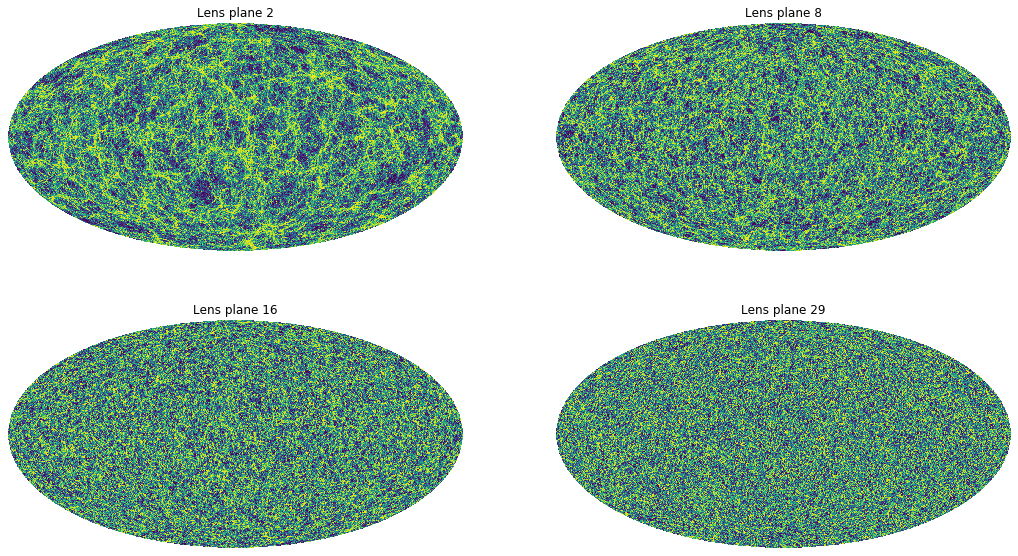

In [13]:
snaps = ([2, 8, 16, 29])
ax = 0
fpath = '/cosma6/data/dp004/dc-boot5/lensplanes/OnionSkin_100Mpc/'
fig, axs = plt.subplots(2,2, figsize=(18,10))
for k in snaps:
    fname = fpath + 'Lens_plane_{0:0d}_nside_{1:0d}'.format(k, nside)
    sigma = hp.read_map(fname, dtype = np.float32, verbose= False)
    sig2 = hp.ud_grade(sigma,256)
    plt.axes(axs[ax//2,ax%2])
    hp.mollview(sig2, norm = 'hist', title = 'Lens plane {0:0d}'.format(k), hold=True, cbar = False, xsize = 1200)
    ax+=1
#plt.savefig('lens_planes.pdf', format = 'pdf')

In [14]:
# downsample healpix kappa map
nside_new = 2048
kappa_map2 = hp.ud_grade(kappa_map, nside_new )
print ('Completed downsampling')

Completed downsampling


In [25]:
kappa_map1 = kappa_map2 - kappa_map2.min() + 0.0001

## Shot noise

$$ C_l(\kappa) =\frac{9H_0^4\Omega_m^2}{4c^4}~\sum_j ~d\chi_j~ \frac{1}{\bar{N_j}} (1+z_j)^2\frac{(\chi_s-\chi_j)^2}{\chi_s^2} $$


In [15]:
# Calculate shot noise
N=30
d_chi = 100
SN = 0
SN0 = 0
W = 3/2 * H_0**2 * O_m / const.c.value**2  # Weyl conversion factor
for k in range(N):
    chi_k = (k+0.5) * d_chi/h
    
     # Calculate redshift for this lens
    z = z_at_value(Planck15.comoving_distance,chi_k*unit.Mpc)
  
    # calculate lensing efficiency factor
    q = (1+z) * (N-k-0.5)/N

    # calculate shot noise for this lens plane using limber approximation
    SN0 += d_chi/h * q**2 * W**2 / N_bar[k] # this is WRONG, N_bar should be particle density per unit of spatial volume, not per pixel
    
    SN += d_chi/h  * q**2 * W**2 * 4 * np.pi * chi_k**2 * d_chi / N_parts[k]

print ('Shot noise =', SN0, 'new=', SN)

Shot noise = 7.182119952229664e-11 new= 9.526952183133904e-12


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/cosma/home/dp004/dc-boot5/.conda/envs/python3_env/lib/python3.6/site-packages/healpy/projector.py:846: RuntimeWarning: invalid value encountered in greater
  mask = np.asarray(x) ** 2 + np.asarray(y) ** 2 > 1.0
/cosma/home/dp004/dc-boot5/.conda/envs/python3_env/lib/python3.6/site-packages/healpy/projaxes.py:423: RuntimeWarning: invalid value encountered in greater
  w = np.where(d2 > threshold)[0]


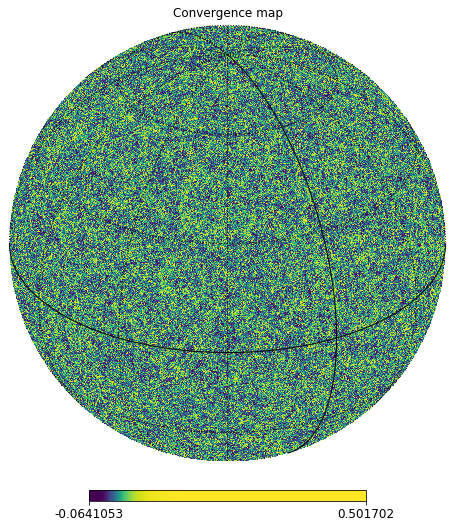

In [16]:
# plot kappa map
fig0 = plt.figure(figsize = (8,8))
hp.orthview(kappa_map2, norm = 'hist', fig = fig0.number, title = 'Convergence map', half_sky = True, rot = (30,30,0))
hp.graticule()
plt.savefig('convergence_map.pdf', format='pdf')

In [17]:
# create zoom-in view of kappa
n = 100
res = 2
x = np.arange(0, n)
y = np.arange(0, n)
xv, yv = np.meshgrid(x, y)

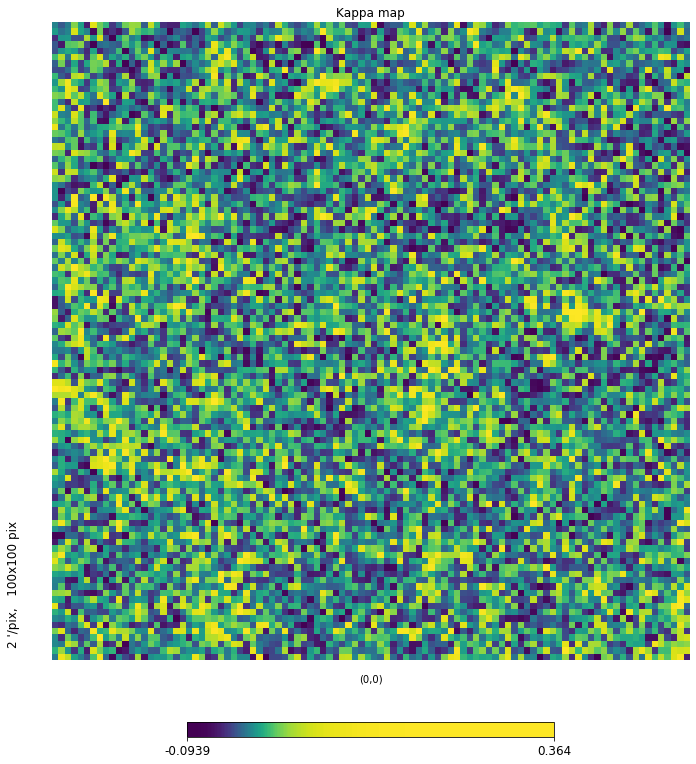

In [18]:
fig2 = plt.figure(figsize = (12,12))
k_map = hp.gnomview(kappa_map, fig = fig2.number, norm = 'hist', xsize = n, reso = res, return_projected_map = True, title = 'Kappa map')

In [19]:
cdict = {'red':   [[0.00, 0.0, 0.0],
                   [0.05, 0.0, 0.0],
                   [0.40, 1.0, 1.0],
                   [1.00, 1.0, 1.0]],
         'green': [[0.00, 0.0, 0.0],
                   [0.30, 0.0, 0.0],
                   [1.00, 1.0, 1.0]],
         'blue':  [[0.00, 0.0, 0.0],
                   [0.05, 1.0, 1.0],
                   [0.40, 0.0, 0.0],
                   [0.80, 0.0, 0.0],
                   [1.00, 1.0, 1.0]]}

cmap_name = 'blue2'
newcmp2 = LinearSegmentedColormap(cmap_name, segmentdata=cdict, N=256)

In [20]:
cdict = {'red':   [[0.00, 0.0, 0.0],
                   [0.34, 0.0, 0.0],
                   [0.50, 1.0, 1.0],
                   [1.00, 1.0, 1.0]],
         'green': [[0.00, 0.0, 0.0],
                   [0.34, 0.86, 0.86],
                   [0.50, 0.92, 0.92],
                   [1.00, 0.0, 0.0]],
         'blue':  [[0.00, 1.0, 1.0],
                   [0.34, 1.0, 1.0],
                   [0.66, 0.0, 0.0],
                   [1.00, 0.0, 0.0]]}

cmap_name = 'Planck'
newcmp1 = LinearSegmentedColormap(cmap_name, segmentdata=cdict, N=256)

0.0001 0.4579187775041442


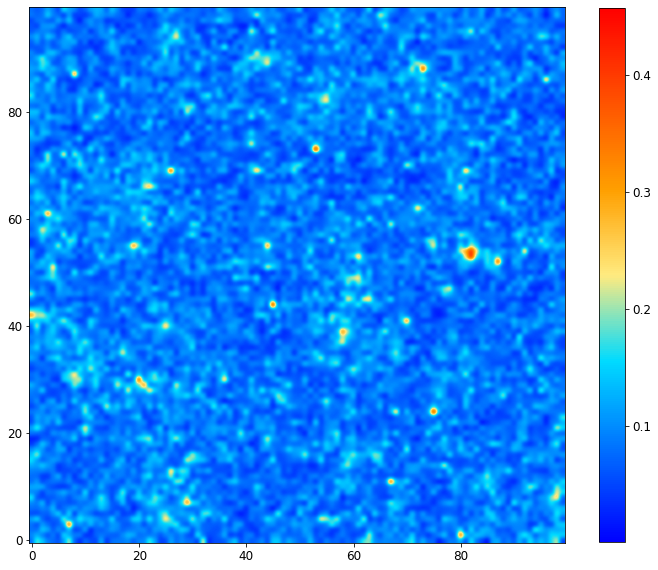

In [21]:
#Cmap = cm.get_cmap('viridis')
#Cmap = cm.get_cmap('hot')
Cmap = newcmp1
Interp =  'gaussian'
#Interp = None
k_map0 = k_map - k_map.min()+ 0.0001
g_min = k_map0.min()
g_max = k_map0.max()
print (g_min, g_max)
#Norm = cm.colors.LogNorm(g_min, g_max)
Norm = cm.colors.Normalize(g_min, g_max)
fig3 = plt.figure(figsize = (12,12))
ax = fig3.gca()
img = ax.imshow(k_map0,cmap = Cmap, norm = Norm, interpolation = Interp, origin='lower')
plt.colorbar(mappable = img,shrink = 0.82)
plt.show()

## Calculate convergence angular power spectrum from $\kappa$ map
Use healpix anafast routine to generate $C_l$s and also $a_{lm}$s for subsequent calcualtion of lensing potential $\psi$

In [ ]:
print('anafast started', datetime.now())
cl, alm = hp.anafast(kappa_map, alm = True)
ell = np.arange(len(cl))
kappa_alm = alm
print('anafast completed', datetime.now(),'number of l values = ', len(cl))

anafast started 2020-05-21 22:53:17.518987


In [25]:
# low res version of kappa
print('anafast started', datetime.now())
cl_kappa2 = hp.anafast(kappa_map2, alm = False)
ell2 = np.arange(len(cl_kappa2))
print('anafast completed', datetime.now(),'number of l values = ', len(ell2))

anafast started 2020-06-17 12:10:45.429020
anafast completed 2020-06-17 12:11:03.687092 number of l values =  6144


In [ ]:
# Save Cls
outpath = '/cosma6/data/dp004/dc-boot5/Power Spectrum/Cl_Spectrum_Sussex/'
fname = outpath + 'Cl_nside_Sigma_nside_{0:0d}_nlp_{1:0d}'.format(nside_new,N)
hp.write_cl(fname, cl, dtype=np.float32,  overwrite = True)
fname = outpath + 'Alm_nside_Sigma_nside_{0:0d}_nlp_{1:0d}'.format(nside_new, N)
hp.write_alm(fname, alm, out_dtype=np.complex128,  overwrite = True)
print ('Saved')

In [23]:
# Read previously saved Cls and alms
outpath = '/cosma6/data/dp004/dc-boot5/Power Spectrum/Cl_Spectrum_Sussex/'
fname = outpath + 'Cl_nside_Sigma_nside_{0:0d}_nlp_{1:0d}'.format(nside,N)
cl_kappa = hp.read_cl(fname)
fname = outpath + 'Alm_nside_Sigma_nside_{0:0d}_nlp_{1:0d}'.format(nside, N)
kappa_alm = hp.read_alm(fname)
ell = np.arange(len(cl_kappa))
print('Done reading Cls')

/cosma/home/dp004/dc-boot5/.conda/envs/python3_env/lib/python3.6/site-packages/healpy/fitsfunc.py:622: ComplexWarning: Casting complex values to real discards the imaginary part
  alm.real[i] = almr
/cosma/home/dp004/dc-boot5/.conda/envs/python3_env/lib/python3.6/site-packages/healpy/fitsfunc.py:623: ComplexWarning: Casting complex values to real discards the imaginary part
  alm.imag[i] = almi


Done reading Cls


In [26]:
sn = np.full(len(ell), SN)

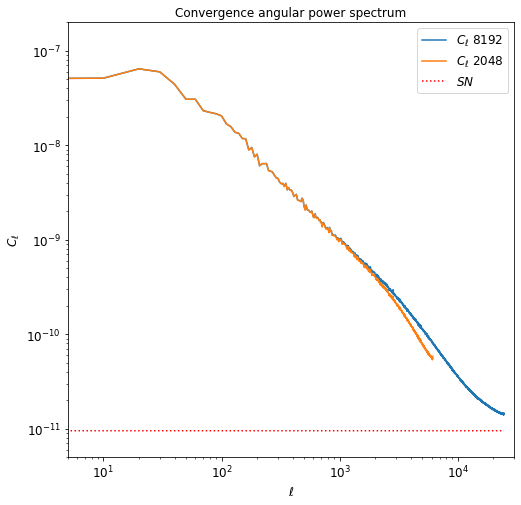

In [27]:
# plot raw Cls
plt.figure(figsize = (8,8))
plt.loglog(ell[::10],cl_kappa[::10], label = '$C_{\ell} ~8192$')
plt.loglog(ell2[::10],cl_kappa2[::10], label = '$C_{\ell} ~2048$')
plt.loglog(ell[::10],sn[::10], linestyle = ':', color = 'r', label = '$SN$')
plt.xlabel('$\ell$', size = 'large')
plt.ylabel('$C_{\ell}$', size = 'large')
plt.xlim(5, 3e4)
plt.ylim(5e-12,2e-7)
plt.legend()
plt.title('Convergence angular power spectrum')
plt.savefig('kappa_cl.pdf', format='pdf')
plt.show()

## Get theoretical predictions from CAMB

In [28]:
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow

In [29]:
lmax = len(cl_kappa)
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=o_b, omch2=o_c)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
#set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = False 
#NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinear = model.NonLinear_both
pars.NonLinearModel.halofit_version = 'takahashi' # default
#Set up W(z) window function
pars.SourceWindows = [GaussianSourceWindow(redshift=1.47, source_type='lensing', sigma=0.01)]
results = camb.get_results(pars)
cls = results.get_source_cls_dict()

In [30]:
# Calculate total angular power spectrum
Cl_kappa = cl_kappa * (ell*(1+ell))/(2*np.pi)
Cl_kappa2 = cl_kappa2 * (ell2*(1+ell2))/(2*np.pi) 
Sn = SN * ( ell*(ell+1))/ (2 * np.pi)

In [31]:
Cl_kappa /= np.sqrt(2)
Cl_kappa2 /= np.sqrt(2)
SN /= np.sqrt(2)

In [32]:
len(Cl_kappa)

24576

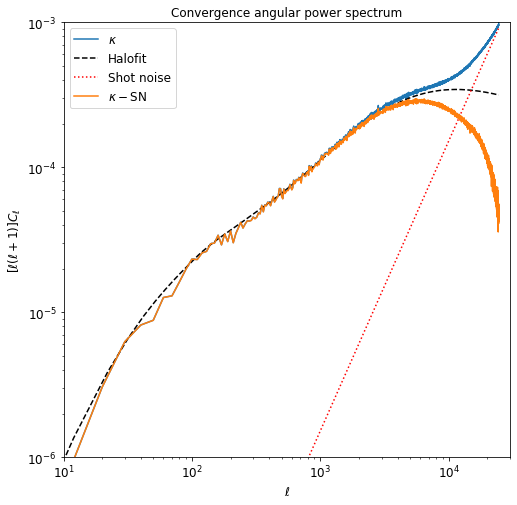

In [33]:
fig = plt.figure(figsize = (8,8))
plt.loglog(ell[::10],Cl_kappa[::10], label = '$\kappa$')
#plt.loglog(ell2[::10],Cl_kappa2[::10], label = 'nside 2048')
plt.loglog(ell[2:lmax:10], cls['W1xW1'][2:lmax:10],linestyle = '--', color = 'k', label='Halofit')
plt.loglog(ell,Sn, linestyle = ':', color = 'r', label = 'Shot noise')
plt.loglog(ell[:-20:10],Cl_kappa[:-20:10] - Sn[:-20:10], label = '$\kappa-$SN')
plt.xlabel('$\ell$', size = 'large')
plt.ylabel('$[\ell(\ell+1)]C_{\ell}$', size = 'large')
plt.ylim(1e-6,1e-3)
plt.xlim(1e1, 3e4)
plt.legend()
plt.title('Convergence angular power spectrum')
plt.savefig('kappa_cl_CAMB.pdf', format= 'pdf')
plt.show()

## Calculate lensing potential and derivatives from $\kappa$

$$ \gamma_{\ell m} = -f(\ell) \kappa_{\ell m}  = \frac{1}{2} f(\ell) \ell (\ell+1) \phi_{\ell m} $$

where $ f(\ell) = \sqrt{(\ell+2).\dfrac{(\ell-1)}{\ell(\ell+1)}} $

In [34]:
def fl_gamma(l):
    return -np.sqrt((l+2)*(l-1)/(l*(l+1)))

In [35]:
def fl_psi(l):
    return  -1/(l*(l+1))

In [36]:
def fl_alpha(l):
    return  2 / np.sqrt(l*(l+1))

In [37]:
# multiply a_lm by -1/(l(l+1)) to calculate psi_lm
# ref: https://github.com/healpy/healpy/blob/master/healpy/src/_sphtools.pyx
# ref: W.Hu Weak Lensing of the CMB: A Harmonic Approach, astro-ph/0001303, 2000

print ('almxfl started',datetime.now(), flush = True)
lmax = hp.Alm.getlmax(kappa_alm.size)
l,m = hp.Alm.getlm(lmax)
l = l[1::]   
psi_alm = kappa_alm
psi_alm[0] = 0
psi_alm[1::] = hp.almxfl(kappa_alm[1::], fl_psi(l))
alpha_alm = kappa_alm
alpha_alm[0] = 0
alpha_alm[1::] = hp.almxfl(kappa_alm[1::], fl_alpha(l))
gamma_alm = kappa_alm
gamma_alm[0]  = 0
gamma_alm[1::] = hp.almxfl(kappa_alm[1::], fl_gamma(l))
print ('almxfl completed',datetime.now(), flush = True)

almxfl started 2020-06-17 12:17:19.924681
almxfl completed 2020-06-17 12:18:01.750520


In [ ]:
# transform back to physical space
psi, d_theta, d_phi = hp.alm2map_der1(psi_alm,nside)
print ('Completed psi calculation')

In [ ]:
# calculate magnitude of alpha from theta and phi
alpha = np.sqrt(d_theta*d_theta + d_phi*d_phi)

In [ ]:
# Visualise lensing potential
fig1 = plt.figure(figsize = (10,10))
hp.mollview(psi, norm = 'hist', fig = fig1.number, title = 'Lensing potential')

In [57]:
# Transform to shear map
print('alm2map started', datetime.now(), flush = True)
gamma_map = hp.alm2map(gamma_alm, nside)
print('gamma map ready', datetime.now())

alm2map started 2020-06-11 10:34:57.698763
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
gamma map ready 2020-06-11 10:36:35.667060


In [58]:
nside_gamma  = 8192
gamma_B_alm = np.zeros(gamma_alm.shape, dtype = np.complex128)
gamma_E_alm = -gamma_alm
print('alm2map started', datetime.now(), flush = True)
kappa0_map, gamma1_map, gamma2_map = hp.alm2map((kappa_alm, gamma_E_alm, gamma_B_alm), nside_gamma)
print('gamma map ready', datetime.now())

alm2map started 2020-06-11 10:44:31.146139
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
gamma map ready 2020-06-11 10:52:40.452873


In [69]:
print('alm2map_spin started', datetime.now(), flush = True)
gamma_B_alm = np.zeros(gamma_alm.shape, dtype = np.complex128)
gamma_E_alm = -gamma_alm
gamma1_map, gamma2_map = hp.alm2map_spin((gamma_E_alm, gamma_B_alm), nside = nside_gamma, spin = 2, lmax = lmax)
print('gamma map ready', datetime.now())

alm2map_spin started 2020-06-11 10:59:58.940249
gamma map ready 2020-06-11 11:09:26.190164


In [71]:
nside_new = 512
gamma1_map2 = hp.ud_grade(gamma1_map, nside_new )

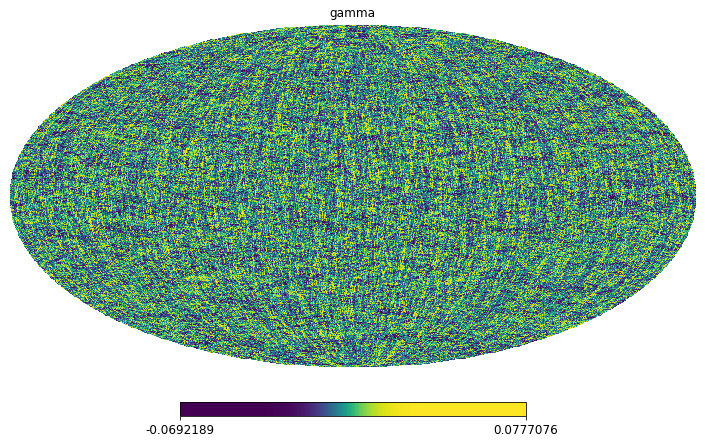

In [72]:
# visualise gamma map
fig4 = plt.figure(figsize = (10,10))
#hp.orthview(gamma_map, norm = 'hist', fig = fig4.number, title = 'gamma', half_sky = True, rot = (0,0,0))
hp.mollview(gamma1_map2, norm = 'hist', fig = fig4.number, title = 'gamma')

In [74]:
nside_low = 256
gamma_map2 = hp.ud_grade(gamma_map, nside_low )

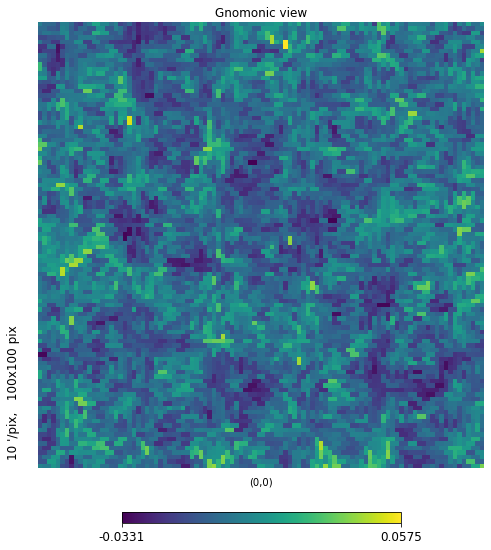

In [83]:
n = 100
res = 10.0
fig = plt.figure(figsize = (10,10))
hp.gnomview(gamma_map2, xsize = n, reso = res, hold=True, return_projected_map =False)

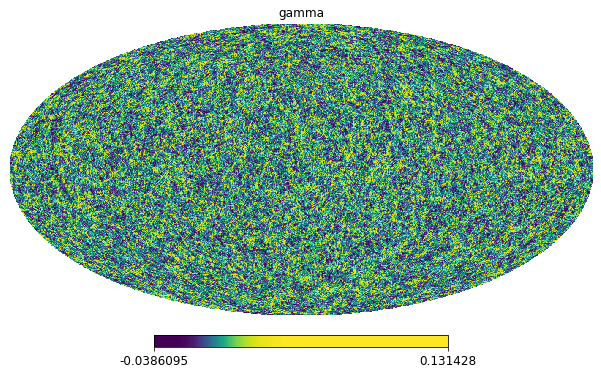

In [84]:
hp.mollview(gamma_map2, norm = 'hist', fig = fig4.number, title = 'gamma')

In [30]:
# Transform to alpha map
print('alm2map started', datetime.now(), flush = True)
alpha_map = hp.alm2map(alpha_alm, nside)
print('alpha map ready', datetime.now())

alm2map started 2020-05-21 18:07:44.952439
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
alpha map ready 2020-05-21 18:09:23.263625


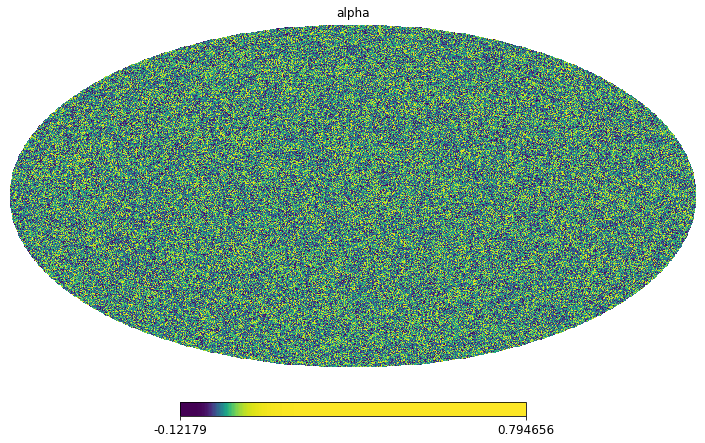

In [31]:
# visualise alpha map
fig3 = plt.figure(figsize = (10,10))
#hp.orthview(alpha_map, norm = 'hist', fig = fig3.number, title = 'alpha', half_sky = True, rot = (0,0,0))
hp.mollview(alpha_map, norm = 'hist', fig = fig3.number, title = 'alpha')

In [121]:
n = 100
res = 10.0
x = np.arange(0, n)
y = np.arange(0, n)
X, Y = np.meshgrid(x, y)

In [122]:
nside_new = 8192 #nside_gamma

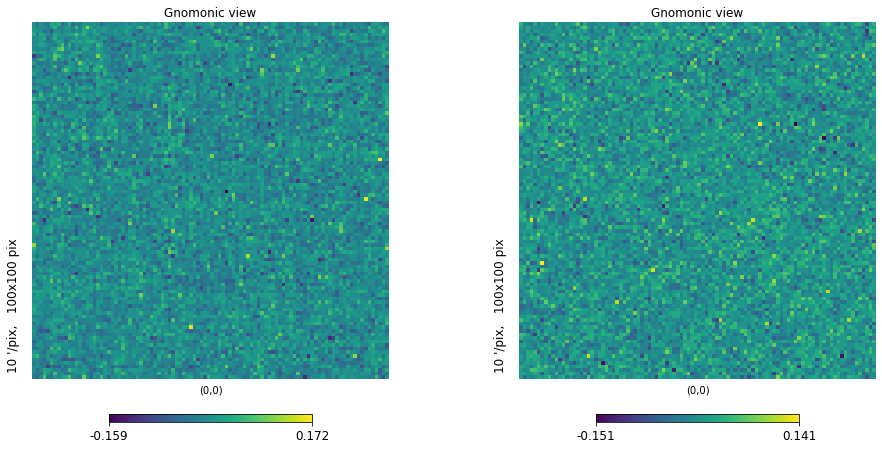

In [123]:
fig0, axs = plt.subplots(1,2, figsize = (16,8))
plt.sca(axs[0])
#hp.mollview(gamma1_map, norm = 'hist',hold=True,)
gam1 = hp.gnomview(gamma1_map, xsize = n, reso = res, hold=True, return_projected_map =True)
plt.sca(axs[1])
#hp.mollview(gamma2_map, norm = 'hist',hold=True,)
gam2 = hp.gnomview(gamma2_map, xsize = n, reso = res, hold=True, return_projected_map =True)
plt.show()

In [128]:
nside_low = 256
gamma_map2 = hp.ud_grade(gamma_map, nside_low )
gamma1_map2 = hp.ud_grade(gamma1_map, nside_low )
gamma2_map2 = hp.ud_grade(gamma2_map, nside_low )
print ('done downscaling')

done downscaling


In [135]:
kappa_map2 = hp.ud_grade(kappa_map, nside_low )

In [129]:
# Create projections for kappa and gamma maps
proj = hp.projector.GnomonicProj(xsize = n, reso = res, rot = (30,30,0))
#proj = hp.projector.MollweideProj(xsize = n)
#proj = hp.projector.CartesianProj(xsize = n)

kap_map = proj.projmap(kappa_map2, vec2pix_func=partial(hp.vec2pix, nside_low))
gam_map = proj.projmap(gamma_map2, vec2pix_func=partial(hp.vec2pix, nside_low))
u = proj.projmap(gamma1_map2, vec2pix_func=partial(hp.vec2pix, nside_low))
v = proj.projmap(-gamma2_map2, vec2pix_func=partial(hp.vec2pix, nside_low))

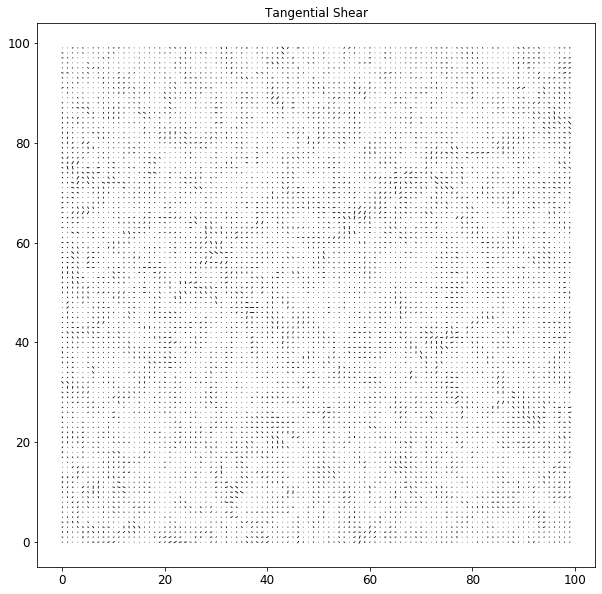

In [130]:
# visualise shear map
fig5 = plt.figure(figsize = (10,10))
ax = fig5.gca()
s  = 1
qiv  = ax.quiver(X[::s,::s],Y[::s,::s],u[::s,::s],v[::s,::s], pivot ='mid', scale= 5, width = 0.0015, headlength=0, headwidth=0, headaxislength=0)
plt.title('Tangential Shear')
plt.show()

In [131]:
gam_map.max(), gam_map.min()

(0.0701829771724205, -0.029896299731331212)

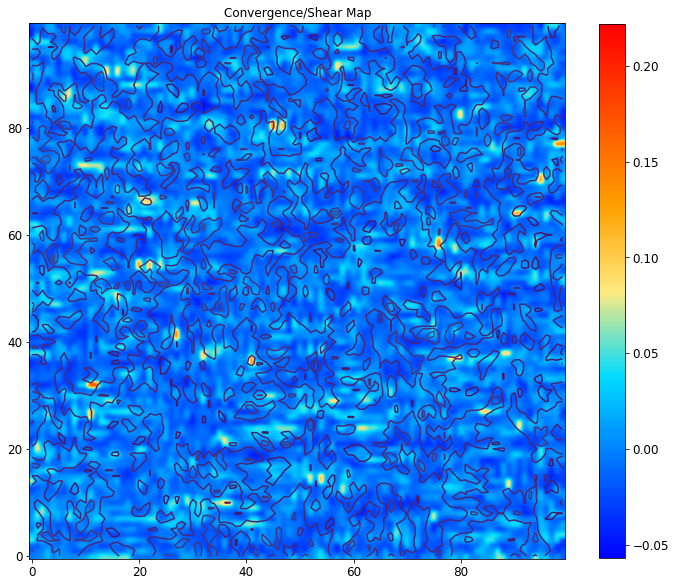

In [140]:
## combine convergence and shear maps
#Cmap = cm.get_cmap('viridis')
levs = ( -0.05,-0.02, 0.0, 0.02, 0.05, 0.1, 0.2, 0.4)
Cmap = newcmp1
Interp ='gaussian' #'bicubic'
g_min = kap_map.min()
g_max = kap_map.max()
#Norm = cm.colors.LogNorm(abs(g_min), g_max + abs(g_min))
Norm = cm.colors.Normalize(kap_map.min(), kap_map.max())
fig4 = plt.figure(figsize = (12,12))
ax = fig4.gca()
img = ax.imshow(kap_map,cmap = Cmap, norm = Norm, interpolation = Interp, origin='lower')
#img = ax.imshow(gam_map,cmap = Cmap, norm = Norm, interpolation = Interp, origin='lower')
cnt = plt.contour(X,Y,gam_map, levels = levs)
#cnt = plt.contour(X,Y,u, levels = 5)
#qiv  = ax.quiver(X[::s,::s],Y[::s,::s],u[::s,::s],v[::s,::s], pivot ='mid', scale= 5, width = 0.0015, headlength=0, headwidth=0, headaxislength=0, color = 'k')
plt.title('Tangential Shear')
plt.colorbar(mappable = img,shrink = 0.82)
plt.title('Convergence/Shear Map')
#plt.savefig('Shear plot: nside = {0:0d}, pixels = {1:0d}, res = {2:0.0f}.pdf'.format(nside,n, res), format='pdf')
plt.savefig('convergence_shear_map.pdf'.format(nside,n, res), format='pdf')
plt.show()

## Calculate shear power spectrum from $\kappa$

[Ref: Fosalba 2015, eqn 9]

> In turn shear maps, $\gamma (\hat{\rm{n}})$, can be simply obtained by decomposing all-sky lensing maps in spherical harmonics (see Hu 2000):
> 
> $$ \gamma_{\ell m} = - f(\ell) \kappa_{\ell m}  = \frac{1}{2} f(\ell)\ell(\ell+1) \phi_{\ell m}$$
>
> with, $f(\ell)=\sqrt{(\ell+2)(\ell-1)/(\ell(\ell+1))}$.
> 
> Assuming that, for the cosmological weak-lensing signal, the B-mode is zero, the shear E-mode harmonic coefficients read,
> $E_{\ell m}=\gamma_{\ell m}$, whereas the $(\gamma_1,\gamma_2)$ "Stokes " parameters of the shear field,
>
> $$\gamma_1(\hat{\rm{n}}) \pm i\gamma_2(\hat{\rm{n}}) = \sum_{\ell m}\gamma_{\ell m} Y_{\ell m}(\hat{\rm{n}})$$
> are then obtained transforming back the $E_{\ell m}$'s to real space.


Castro et al, 2008 (arXiv:astro-ph/0503479v2):

$$ a_{E, lm} (k) = \frac{1}{2} \left( \dfrac{(l+2)!}{(l-2)!} \right) \phi_{lm}(k) $$

and

$$ \gamma_{1,lm}(k) = \gamma_{2,lm}(k) = -a_{E,lm}(k) $$



In [476]:
# Calculate gamma from gamma a_lm's
print('alm2cl started', datetime.now(), flush = True)
cl_gamma = hp.alm2cl(gamma_alm)
print('alm2cl completed', datetime.now(), flush = True)

alm2cl started 2020-04-15 18:01:05.442256
alm2cl completed 2020-04-15 18:01:07.972412


In [540]:
# transform back to physical space
print('alm2map_der1 started', datetime.now(), flush = True)
gamma, d_theta, d_phi = hp.alm2map_der1(gamma_alm,nside)
print('gamma completed', datetime.now(), flush = True)

alm2map_der1 started 2020-04-17 09:31:00.827867
gamma completed 2020-04-17 09:37:03.578784


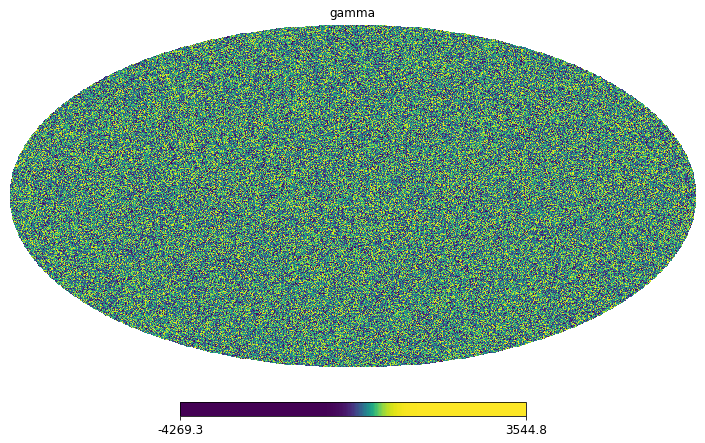

In [544]:
# visualise gamma map
fig4 = plt.figure(figsize = (10,10))
hp.mollview(d_theta, norm = 'hist', fig = fig4.number, title = 'gamma')

In [166]:
# Calculate shear angular power spectrum 
Cl_gamma = cl_gamma * ((ell*(1+ell))/(2*np.pi)) / np.sqrt(2)
spl = UnivariateSpline(ell, Cl_gamma, s=0)

In [177]:
L = np.logspace(1, 4.5, 30)

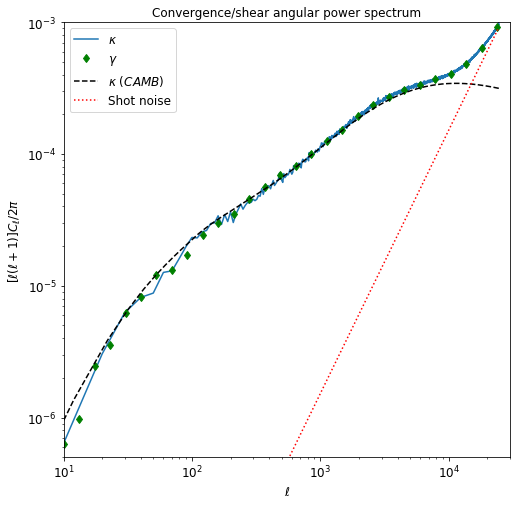

In [183]:
# display combined results

fig6 = plt.figure(figsize=(8,8))
plt.loglog(ell[::10],Cl_kappa[::10], label = '$\kappa$')
#plt.loglog(ell[200::100],Cl_gamma[200::100], linestyle='None', marker='o',color = 'g', label = '$\gamma$')
#plt.loglog(ell[:200:10],Cl_gamma[:200:10], linestyle='None', marker='d', color = 'g')
plt.loglog(L, spl(L), linestyle='None', marker='d',color = 'g', label = '$\gamma$')
plt.loglog(ell[2:lmax:10], cls['W1xW1'][2:lmax:10], linestyle = '--', color = 'k', label='$\kappa ~(CAMB)$')
plt.loglog(ell,Sn, linestyle = ':', color = 'r', label = 'Shot noise')
plt.xlim(1e1,3e4)
plt.ylim(5e-7, 1e-3)
plt.title('Convergence/shear angular power spectrum')
plt.ylabel('$[\ell(\ell+1)]C_{\ell}/2 \pi$')
plt.xlabel('$\ell$')
plt.legend()
plt.savefig('shear_angular_power_spectrum.pdf', format ='pdf')
plt.show()

## Calculate alpha power spectrum from $\kappa$

The gradient of the lensing potential gives the deflection angle, (Hu, 2000)
$$\alpha(\hat{\rm{n}}) = \nabla \phi(\hat{\rm{n}}) $$

and the coefficients of its spherical harmonic transform read,
$$ \alpha_{\ell m} = -\sqrt{\ell(\ell+1)} \phi_{\ell m} $$

$$ \rightarrow \alpha_{\ell m} =  \kappa_{\ell m}. \dfrac{2}{\sqrt{\ell(\ell+1)}}$$


so that the corresponding power spectra are simply related, $C_{\ell}^{\alpha}= \ell(\ell+1) C_{\ell}^{\phi}$.


In [385]:
# Calculate Cl_alpha from alpha a_lm's
print('alm2cl started', datetime.now())
cl_alpha = hp.alm2cl(alpha_alm)
print('alm2cl completed', datetime.now())

alm2cl started 2020-04-15 16:09:46.510483
alm2cl completed 2020-04-15 16:09:48.894881


In [440]:
# Calculate Cl_alpha from first derivatives of lensing potential Psi
print('anafast started', datetime.now())
cl_alpha2 = hp.anafast(alpha, alm = False)
ell = np.arange(len(cl_alpha2))
print('anafast completed', datetime.now(),'number of l values = ', len(ell))

anafast started 2020-04-15 17:19:09.522450
anafast completed 2020-04-15 17:30:30.179627 number of l values =  24576


In [489]:
# Calculate alpha angular power spectrum 
Cl_alpha = cl_alpha 
Cl_alpha2 = cl_alpha2 
Cls = cls['W1xW1'][2:lmax+3:] / (ell*(1+ell)) 

/cosma/home/dp004/dc-boot5/.conda/envs/python3_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


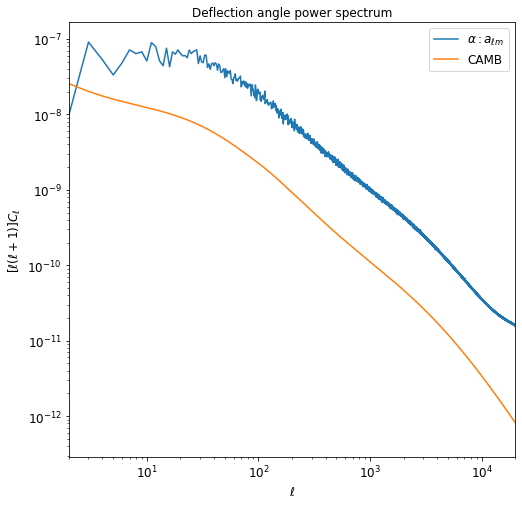

In [490]:
# display combined results
fig6 = plt.figure(figsize=(8,8))
plt.loglog(ell,Cl_alpha , label = '$\\alpha: a_{\ell m}$')
#plt.loglog(ell,Cl_alpha2 , label = '$\\alpha: \\nabla \psi$')
plt.loglog(ell,Cls , label = 'CAMB')
plt.xlim(2e0,2e4)
#plt.ylim(1e-22, 1e-9)
plt.title('Deflection angle power spectrum')
plt.ylabel('$[\ell(\ell+1)]C_{\ell}$')
plt.xlabel('$\ell$')
plt.legend()
plt.show()

## Read 3D power spectrum generated during lightcone construction

In [186]:
powerspec_path = '/cosma6/data/dp004/dc-boot5/Lightcone/Power_Spectrum/'

# read first snapshot to get k size
fname = 'powerspec_063.npy'
fi = h5py.File(powerspec_path + fname,'r')
ks = fi['k']    
print (len(ks))

1773


In [263]:
nsnaps = 21
h = 0.70
P_k = np.zeros((nsnaps,len(ks)))
z = np.zeros(nsnaps)
for i in range(nsnaps):
    snap = 63-i
    fname = 'powerspec_{0:03d}.npy'.format(snap)
    fi = h5py.File(powerspec_path + fname,'r')
    P_k[i] = fi['Pk0']
    z[i] = fi['attribs'].attrs['z'] / h
    print ('Read shapshot ', snap,' z = ', z[i])

Read shapshot  63  z =  3.1720657846433045e-16
Read shapshot  62  z =  0.021998137951677283
Read shapshot  61  z =  0.06701585800434895
Read shapshot  60  z =  0.09004595281855694
Read shapshot  59  z =  0.1371755036655393
Read shapshot  58  z =  0.16128596557447394
Read shapshot  57  z =  0.21062641552261516
Read shapshot  56  z =  0.26149812230552066
Read shapshot  55  z =  0.287522990495204
Read shapshot  54  z =  0.340781145032851
Read shapshot  53  z =  0.39569214045922796
Read shapshot  52  z =  0.4523072718863646
Read shapshot  51  z =  0.5106794263451103
Read shapshot  50  z =  0.5708631321895599
Read shapshot  49  z =  0.6646588080186224
Read shapshot  48  z =  0.7296211889835467
Read shapshot  47  z =  0.7965996458042771
Read shapshot  46  z =  0.9009848699332996
Read shapshot  45  z =  0.973281515136185
Read shapshot  44  z =  1.0859550802121707
Read shapshot  43  z =  1.1639921858084024


In [264]:
# Create 2D spline for P_k(k, z)
Pk = RectBivariateSpline(z, ks, P_k, s=0)

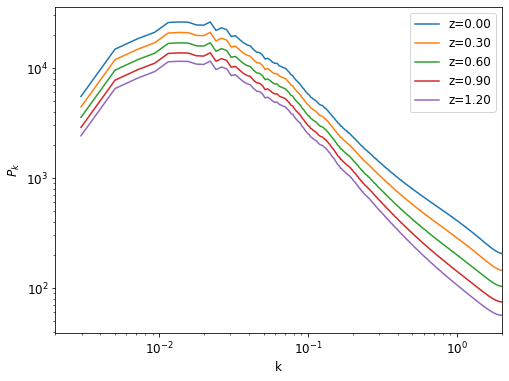

In [265]:
zs = np.linspace(0,1.2,5)
for z in zs:
    plt.loglog(ks, Pk(z, ks)[0], label = 'z={0:0.2f}'.format(z))
plt.xlabel('k')
plt.ylabel('$P_k$')
plt.xlim(2e-3, 2e0)
plt.legend()
plt.savefig('matter_power_spec.pdf', format = 'pdf')
plt.show()

## Calculate $C_{\ell}$ by performing a Limber integral of 3D power spectrum

$$
C_l = \dfrac{9}{16} \left(\dfrac{H_0}{c} \right)^4 \Omega_m^2 \int_0^{\chi_h}{d\chi \left[\dfrac{g(\chi)}{ar(\chi)} \right]^2  P \left(\dfrac{l}{r}, \chi \right)}
$$

where weighting function
$g(x) = 2 \dfrac{r(\chi) r(\chi_s - \chi)}{r(\chi_s)}$ where $r \equiv D_A$

or 
$$
C_k(\ell) = \int_0^{\chi_s}{d\chi  q_{ds}^2 P_m \left(\dfrac{\ell}{\chi_d}, z_d \right)}
$$
where $q_{ds} =  \dfrac{3}{2} \left(\dfrac{H_0}{c} \right)^2 \Omega_m (1 +z_d) \dfrac{\chi_d(\chi_s - \chi_d)}{\chi_s}$

In [266]:
nz = 2**8 + 1
chi_star = 3000 / 0.67 #Mpc /h
dchi = chi_star/nz
chis = np.linspace(dchi,chi_star,nz)
ls = np.arange(2,lmax)

In [267]:
def m2w(camb_results,ztest):
    norm=3/2*(camb_results.get_Omega('cdm',ztest)+camb_results.get_Omega('baryon',ztest))* ((camb_results.hubble_parameter(ztest) * 1000/const.c.value)/(1+ztest))**2
    #norm=3/2*(camb_results.get_Omega('cdm',ztest)+camb_results.get_Omega('baryon',ztest))* ((camb_results.hubble_parameter(ztest) * 1000/const.c.value))**2

    return norm

In [268]:
def matter2weyl(camb_results,ztest):
    norm=9*0.25*((camb_results.get_Omega('cdm',ztest)+camb_results.get_Omega('baryon',ztest))**2)*(camb_results.h_of_z(ztest)/(1+ztest))**4
    return norm

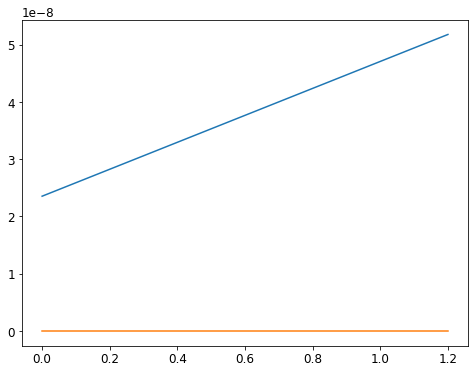

In [269]:
plt.plot(zs, m2w(results,zs))
plt.plot(zs, matter2weyl(results, zs))
plt.show()

In [270]:
cl_kappa0 = np.zeros(ls.shape)
cl_noise = np.zeros(ls.shape)
    
# Calculate scale factor and growth factor for each chi
zs=results.redshift_at_comoving_radial_distance(chis)
    
# calculate weighting function
#W = ((chi_star-chis)/(chis**2*chi_star))**2
W = ( (chi_star-chis)/chi_star)**2 * (1+zs)

for i, l in enumerate(ls):
    k = (l+0.5)/chis
    #Do integral over chi
    cl_kappa0[i]  = np.sum(np.multiply(dchi, m2w(results,zs)**2  * Pk(zs,k, grid=False) * W))    
    #cl_noise[i]  = np.sum(np.multiply(dchi, m2w(results,zs) * (1+zs)**2 * 1/SN(zs) * W )) #/k**4))   

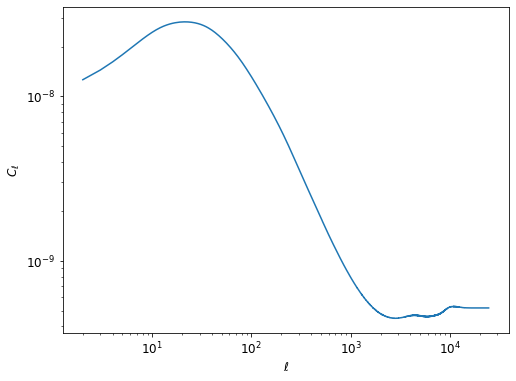

In [271]:
plt.loglog(ls, cl_kappa0)
plt.loglog(ls, cl_noise)
plt.ylabel('$C_{\ell}$')
plt.xlabel('$\ell$')
plt.show()

In [272]:
cl_k = cl_kappa0 * ls*(ls+1)/(2* np.pi)
cl_n = cl_noise * ls*(ls+1)**2/(2* np.pi)

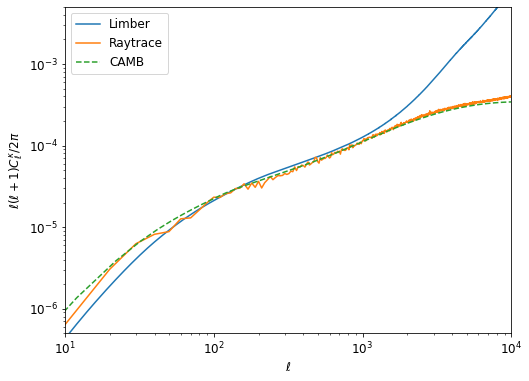

In [276]:
plt.loglog(ls, cl_k,label='Limber')
plt.loglog(ell[::10],Cl_kappa[::10], label = 'Raytrace')
#plt.loglog(ls, cl_n, label = 'Noise')
plt.loglog(ell[2:lmax:10], cls['W1xW1'][2:lmax:10],linestyle = '--', label='CAMB')
plt.ylabel('$\ell(\ell+1)C_{\ell}^{\kappa}/2\pi$')
plt.xlabel('$\ell$')
plt.legend()
plt.ylim(5e-7, 5e-3)
plt.xlim(1e1, 1e4)
#plt.savefig('limber_powerspec.pdf', format='pdf')
plt.show()

In [223]:
hp.__version__

'1.13.0'

In [228]:
hp.alm2map_spin?

Docstring:
alm2map_spin_healpy(alms, nside, spin, lmax, mmax=None)
Computes maps from a set of 2 spinned alm

    Parameters
    ----------
    alms : list of 2 arrays
      list of 2 alms
    nside : int
        requested nside of the output map
    spin : int
        spin of the alms (either 1, 2 or 3)
    lmax : int, scalar
      Maximum l of the power spectrum.
    mmax : int, scalar, optional
      Maximum m of the alm. Default: lmax

    Returns
    -------
    m : list of 2 arrays
        list of 2 out maps in RING scheme as numpy arrays
    
Type:      builtin_function_or_method
